# Filtering in the Time Domain: Part I

In this section, we will explore some simple techniques to filter time series in the *time domain*. To familiarize ourselves with the concept of filtering, we will take a look at a two common examples of filtering in the fields of climate science and geophysics.

## Example 1: Filtering out the Long-term Trend

As we discussed in the previous section, autocorrelation in a time series means that the data are not indepedent and that the sample size is an overestimate. Autocorrelation is often the result of a *long-term trend*. So, one way around this is to remove the long-term trend. 

Let's start by returning to our TLT temperature time series example in the [previous section](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week5/autocorr_example.html) to examine filtering of the long-term trend.

In [1]:
# Load packages
import numpy as np
import scipy.stats as st
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle
mpl.rc('font',size=14,weight='bold') #set default font size and weight for plots

Read in monthly TLT data starting in Jan. 1979 - Dec. 2019. The file is [here](https://github.com/kls2177/ccia_files/blob/master/TLT_19792019.csv?raw=true).

In [2]:
# Read in TLT file
filename = 'TLT_19792019.csv'
T = np.squeeze(np.genfromtxt(filename,delimiter=','))

# Extract Dec. 1979 - November 2019 and just extract last column (temperature data)
T = T[11:-1,2]

# Alternative way to compute the seasonal averages
T_seasons = np.mean(T.reshape(-1, 3), axis=1)

Recall that this data set has contains a long-term trend. Let's plot the data to remind ourselves of how it looks.

Text(0.5, 1.0, 'Seasonal TLT Time Series (1980-2019)')

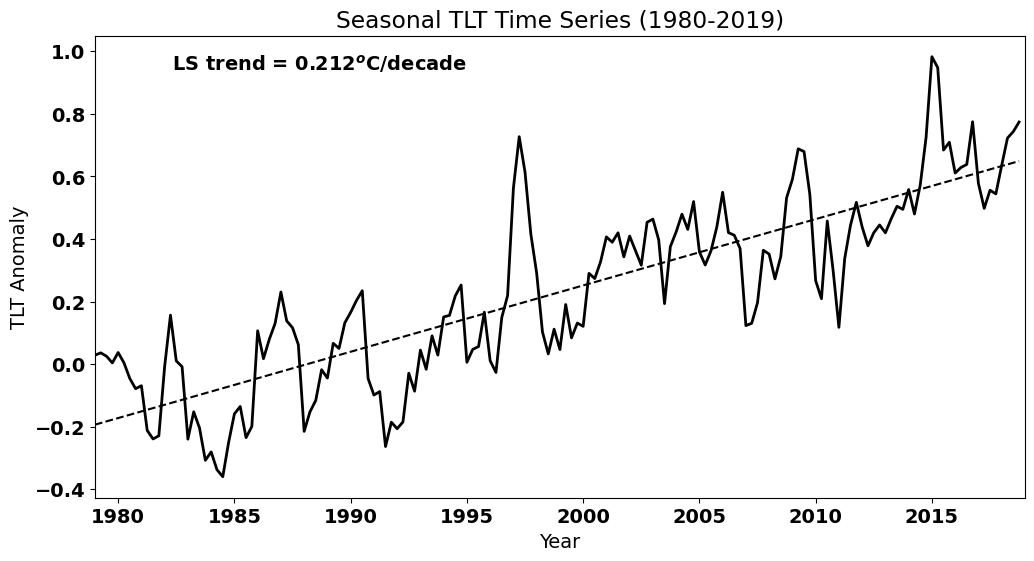

In [3]:
# Create time index for plotting and for regression
time = np.arange(0,len(T_seasons),1)

# Plot the data (update to Fig. 3 of Santer et al. 2000)
plt.figure(figsize=(12,6))

# plot time series
plt.plot(time,T_seasons,'k',linewidth=2)

# calculate best-fit line
a = np.polyfit(time,T_seasons,1)
T_hat = np.polyval(a,time)

# plot best-fit line
plt.plot(time,T_hat,'k',linestyle='--')

# ticks, labels, etc.
plt.xticks(np.arange(4,len(time),20),["1980","1985","1990","1995","2000","2005","2010","2015"])
plt.xlim(0,len(time)) 
plt.text(0.4, 0.925,'LS trend = ' + str(np.round(a[0]*40,3)) + '$^o$C/decade', ha='right', 
         transform=plt.gca().transAxes, color = 'k') #we multiply by 40 because our unit of time is seasons but we
                                                        #want to report the trend in deg C per decade
plt.ylabel("TLT Anomaly")
plt.xlabel("Year")
plt.title("Seasonal TLT Time Series (1980-2019)")

As we saw, this trend introduces high autocorrelation at non-zero lags. How would you filter out this trend? We have done this before. Think about it before you reveal the code below.

In [4]:
# detrend the TLT temperature time series
T_dtr = T_seasons - T_hat

We also saw in the previous section that this *detrended* temperature time series has reduced autocorrelation relative to the original time series. Let's go through this calculation again.

In [5]:
# np.correlate actually gives the covariance. We need to find the covariance of the deviations from the mean and then
#  divide the the tau=0 covariance, i.e., the variance to get the correlation

Tcorr = np.correlate((T_seasons-np.mean(T_seasons)),(T_seasons-np.mean(T_seasons))/(len(T_seasons)*np.var(T_seasons)),'same')
Tcorr_dtr = np.correlate((T_dtr-np.mean(T_dtr)),(T_dtr-np.mean(T_dtr))/(len(T_dtr)*np.var(T_dtr)),'same')

The autocorrelation functions clearly show that we have successfully removed some of the high autocorrelation in our time series.

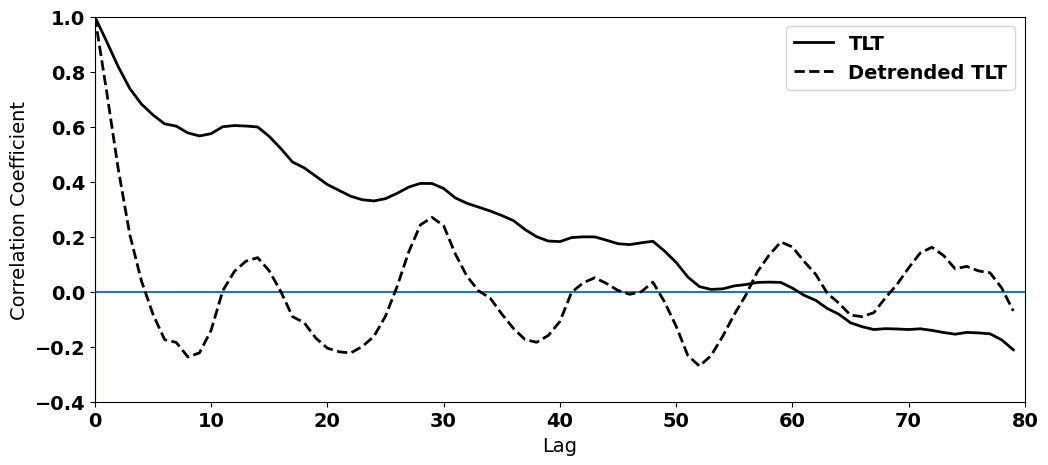

In [6]:
#plot the autocorrelation function
fig = plt.figure(figsize=(12,5))

# x-value for plotting
x = np.arange(0,len(T_seasons),1)
series = [i-len(T_seasons)/2.0 for i in x]

#plot series
plt.axhline(0)
plt.axvline(0)
plt.plot(series[int(len(T_seasons)/2):],Tcorr[int(len(T_seasons)/2):],'k',linewidth=2,label="TLT")
plt.plot(series[int(len(T_seasons)/2):],Tcorr_dtr[int(len(T_seasons)/2):],'k--',linewidth=2,label="Detrended TLT")
plt.xlim(0,80)
plt.ylim(-0.4,1)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')
plt.legend(loc='upper right')

In this example, we see how filtering out the long-term trend, i.e. detrending, helps to address (although not fully) the issue of autocorrelated time series. 

Although this tends to be the primary reason that we detrend time series, there may be reasons you may want to detrend. For example, you may want to test specific scientific hypotheses that are not associated with the long-term trend, e.g. you may want to examine the year-to-year relationship between two variables.

## Example 2: Filtering out the Seasonal Cycle

One feature of many climate and geophysical variables that results in autocorrelation is the **seasonal cycle**. In the following example, we will explore different methods to remove the seasonal cycle in order to reduce the autocorrelation. Again, reducing the autocorrelation, may not be the only reason to do this, but it is often the primary reason.

To look at this problem, we will load in some Arctic sea ice extent (SIE) data from a pre-industrial integration of a global climate model (GCM). I have chosen to use data from a *pre-industrial* integration in order to focus on the seasonal cycle rather than the long-term trend that is evident in historical (GCM) integrations. The file is [here](https://github.com/kls2177/ccia_files/blob/master/SIE_Total.pickle?raw=true).

In [7]:
# Read in Arctic SIE data
fname = 'SIE_Total.pickle'
with open(fname,'rb') as fp:
    sie,lat,lon = pickle.load(fp, encoding = 'iso8859')

The data should consist of 400 years of daily (365 days per year) of SIE data. Let's take a look:

In [8]:
# print shape of data
print(sie.shape)

(400, 365)


Let's reshape this data into one long time series, rather than a 2-D array of years and days.

In [9]:
# Convert sie to time series 
#  (I'm using np.ravel() but you can also use np.reshape())
sie_ts = np.ravel(sie)

Now, let's plot the time series to see what it looks like. We will only plot the first 50 years so that we can clearly see the seasonal cycle.

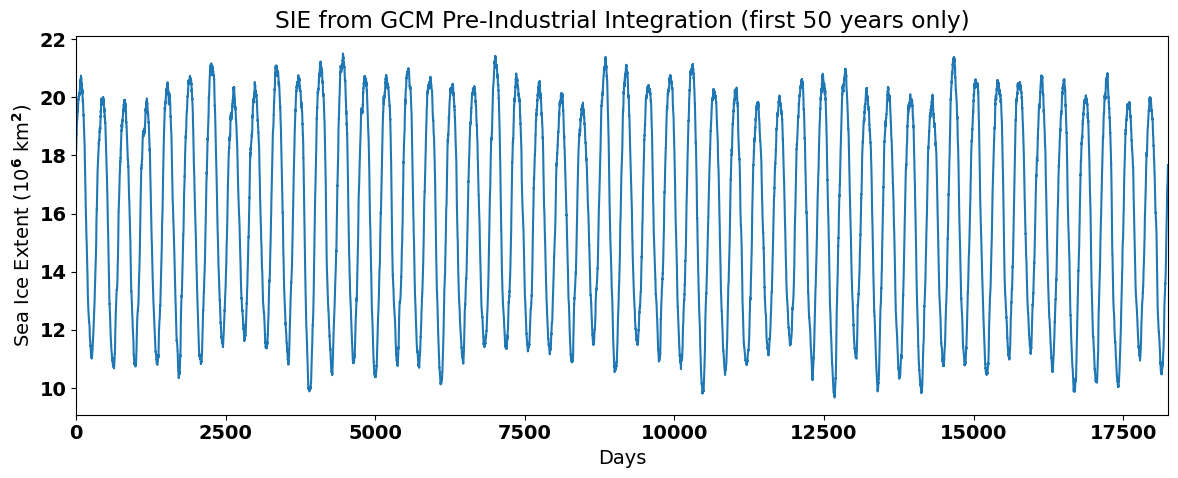

In [10]:
# plot Arctic SIE time series to show the seasonal cycle
plt.figure(figsize=(12,5))

# this data consists of 400 years of daily data, but here I am just plotting 50 years
plt.plot(sie_ts[0:50*365]/1e12) # divide by 10**12 for plotting
plt.xlim(0,50*365)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('SIE from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

### Method 1: Filtering out the Climatological Seasonal Cycle

Previously, we have defined anomalies in the following way:

$$
x_i^\prime(t) = x_i(t) - \overline{x}
$$

for each $i$ in a time series, $i$ = 0, ... ,$N$. 

In other words, we have defined anomalies as the deviation from the time mean. But, the time mean is not that meaningful when we have a large seasonal cycle. Alternatively, we can define anomalies instead by subtracting the seasonal time mean for each day or month of the year:

$$
x_{ij}^\prime(t) = x_{ij}(t) - \overline{x_j}
$$

where $i$ is a year and $j$ is the day of the year (for data with daily temporal resolution). Thus, $\overline{x_j}$ represents the *climatology* or the time mean of the seasonal cycle. If we subtract this, then we should be left with all the variability that is not associated with this time mean seasonal cycle.

Let's take a closer look at the meaning of $\overline{x_j}$ using our Arctic SIE data. [Figure 19](anomaly) shows a section of the Arctic SIE time series with dots added showing values in the time series for all the January 1st's. The black horizontal line shows the average of all the January 1st's. Thus, value of the black line is equal to $\overline{x_j}$, where $j$ = January 1st.

```{figure} anomaly.png
---
scale: 50%
name: anomaly
---
Time series of Arctic sea ice extent from a global climate model pre-industrial integration. The dots represent January 1st and the horizonal black line represents the mean of all the January 1st's.
```

The SIE data that we originally loaded is in a convenient 2-D format for calculating $\overline{x_j}$.

In [11]:
# Take the average over all years to get a 365-day climatology.
sie_clim = np.mean(sie,axis=0)
print(sie_clim.shape)

(365,)


We started with an array with shape (400,365) and after we average over all years, we get an array with shape (365,). 

The climatological seasonal cycle clearly shows the growth and decay of Arctic sea ice over the year.

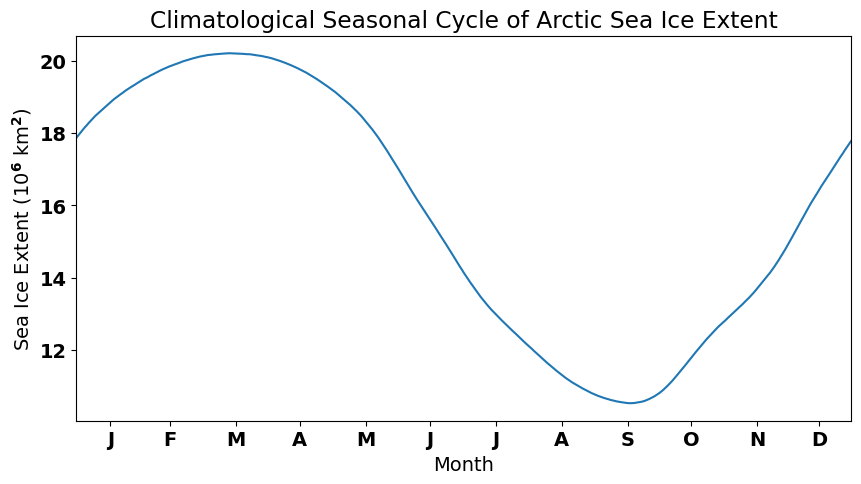

In [12]:
# Plot the seasonal cycle
plt.figure(figsize=(10,5))
plt.plot(sie_clim/1e12)
plt.xlim(0,364)
plt.xticks([16,44,75,105,136,166,197,228,259,289,320,349],
           ["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.xlabel("Month")
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('Climatological Seasonal Cycle of Arctic Sea Ice Extent')
plt.show()

Now, to calculate the anomaly, i.e., to remove the climatological seasonal cycle, we simply subtract the climatology from the total, as in the equation above.

In [13]:
# Remove the 400-year time mean for each day from each day and convert to a long time series again.
sie_anom = sie - sie_clim
sie_deseason1 = np.ravel(sie_anom)

When we plot the anomaly, we should no longer see the large seasonal cycle in the SIE data.

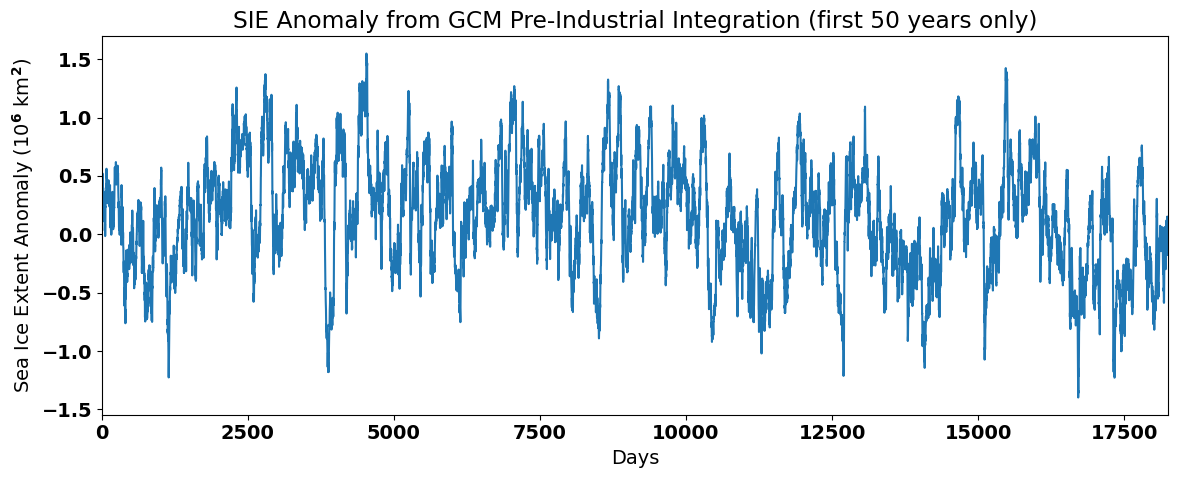

In [14]:
# plot the SIE anomaly
plt.figure(figsize=(12,5))
plt.plot(sie_deseason1[0:50*365]/1e12)
plt.xlim(0,50*365)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent Anomaly (10$^6$ km$^2$)')
plt.title('SIE Anomaly from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

Note that the magnitude of the anomalies is quite small compared to the magnitude of the seasonal cycle. The data looks noisier and does not exhibit a seasonal cycle, but does show some decadal fluctuations. Thus, by removing the seasonal cycle using this method we have **band-pass filtered** the time series, leaving behind variability at both higher and lower frequencies than the seasonal cycle.

The above method for removing the seasonal cycle is the most common in the climate science literature, but may not always be appropriate, for example if the magnitude of the seasonal cycle consistently changes as a function of time. 

### Method 2: Filtering out the Running-Mean Seasonal Cycle

**Running-mean** filters are filters that *low-pass* filter the data by averaging over specific time interval of interest, $L$. Here is an example of a running-mean filter for $L$ = 3:

$$
y(t) = \frac{1}{3}x(t - 1) + \frac{1}{3}x(t) + \frac{1}{3}x(t + 1)
$$

where $y(t)$ is the filtered time series. Similarly, a running-mean filter of $L$ = 5 can be written in the following way,

$$
y(t) = \frac{1}{5}x(t - 2) + \frac{1}{5}x(t - 1) + \frac{1}{5}x(t) + \frac{1}{5}x(t + 1) + + \frac{1}{5}x(t + 2)
$$

If we are interested in removing the seasonal cycle using a running-mean filter, then we need to choose $L$, such that we are smoothing out the seasonal cycle. 

So, for monthly, data, $L$ = 12 and for daily data, $L$ = 365.

Applying such a filter, we end up with a smoothed time series, with the seasonal cycle removed. Let's try this with our Arctic SIE data. We will first write out an expression for a running-mean filter from scratch.

In [15]:
# We can remove the seasonal mean using a 365-day running mean

# initialize array
sie_deseason2 = np.array(np.mean(sie_ts[0:365]))

# Here is the code from scratch
# Loop over elements of sie_ts and compute centred 365-day average each time
for i in range(183,400*365-182):
    sie_deseason2 = np.append(sie_deseason2,np.mean(sie_ts[i-182:i+183]))

The above code illustrates how a running-mean filter works, by looping over each time, $t$ and computing the centred 365-day average each time. Thus, we have the final filtered time series is shorter than the original by 182 days at each end of the time series.

There is a python package called [`np.convolve()`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) that allows us to compute a running-mean filter in one step. The inputa to the function are the time series to be filtered and the filter. In this case the filter is an array of length $L$ divided by $L$. The filter is multiplied by each overlapping 365-day segment of the time series and the function computes the sum of each segment and outputs the filtered time series.

In [16]:
# Here is a nice python package that does the same thing as the code above
sie_deseason3 = np.convolve(sie_ts,np.ones((365,))/365.0,mode='valid')

Notice that the length of the filtered time series is 364 days shorter than the original time series (182 days have been excluded from each end of the time series).

In [17]:
# Printe shapes of filtered and raw time series
print(sie_deseason3.shape[0], sie_ts.shape[0])

145636 146000


Let's plot our new filtered time series and see what it looks like. We will also compare the running-mean method of removing the seasonal cycle to Method 1.

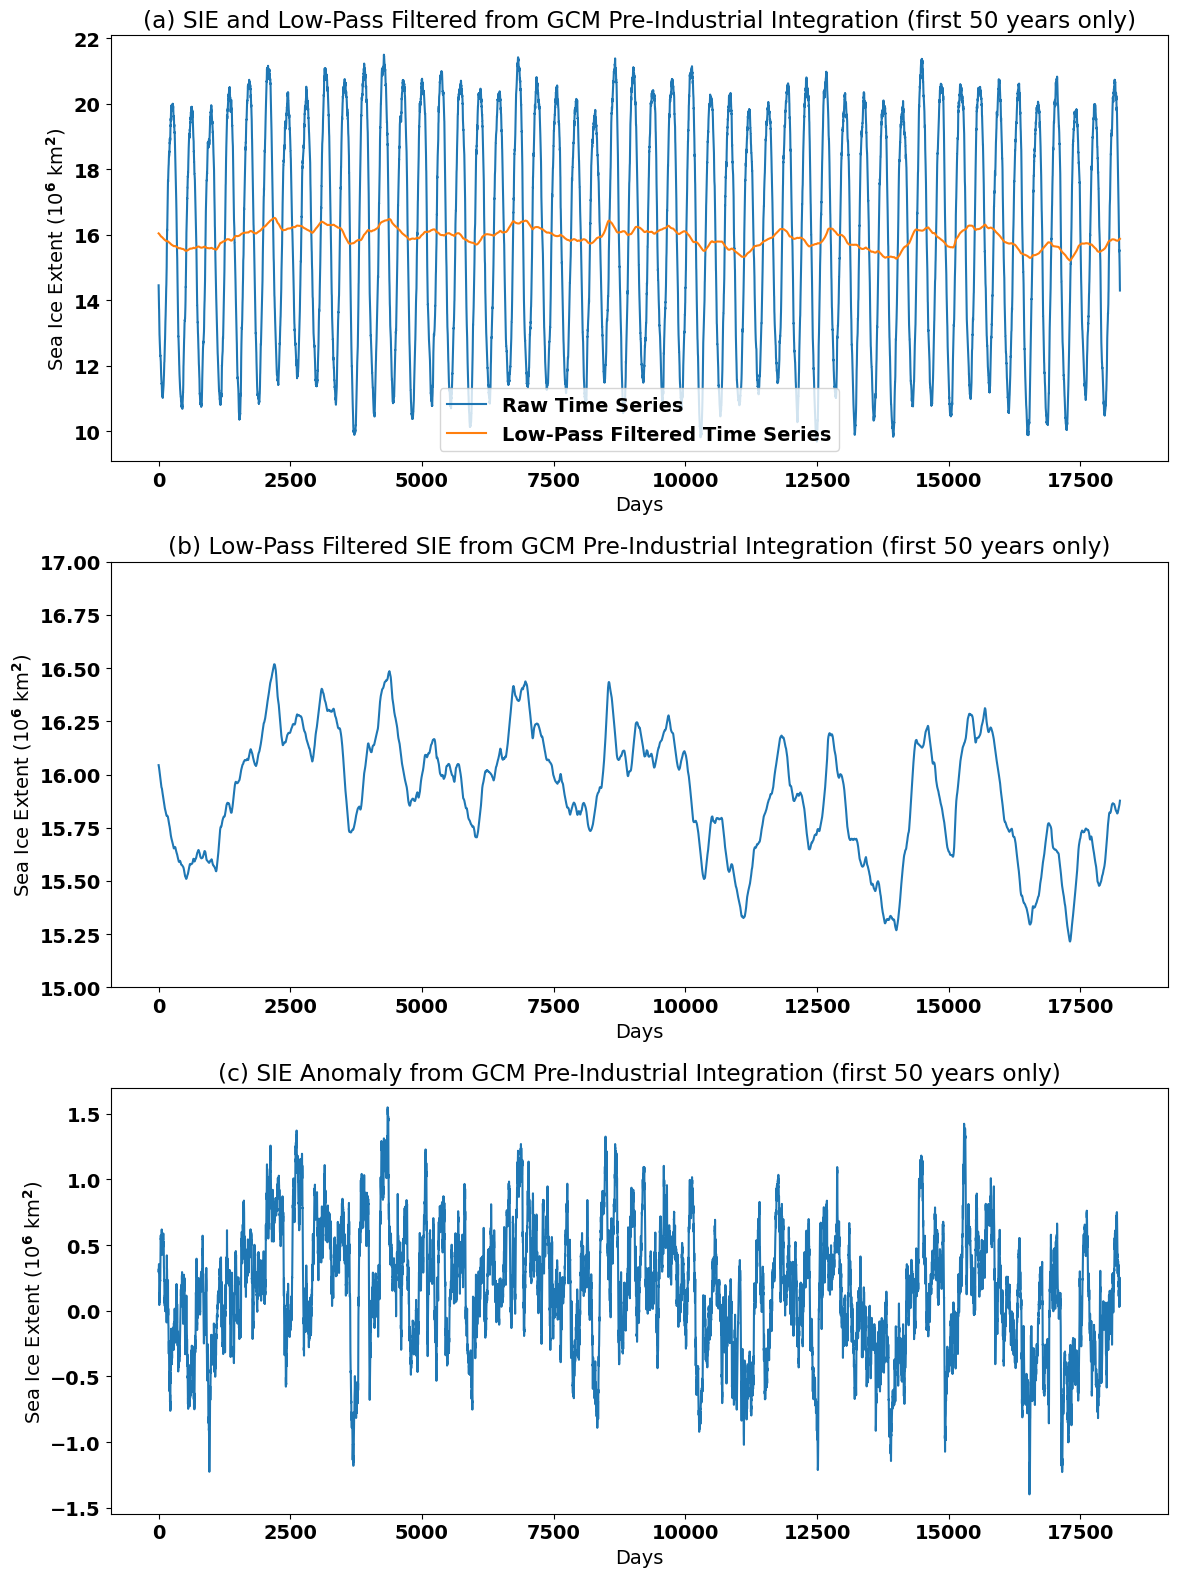

In [18]:
# Plot raw and running-mean filtered time series
plt.figure(figsize=(12,16))
plt.subplot(3,1,1)
plt.plot(sie_ts[182:50*365+182]/1e12, label = "Raw Time Series") # note that the start index is 182 to match the running-mean filter
plt.plot(np.asarray(sie_deseason3[0:50*365])/1e12, label="Low-Pass Filtered Time Series") 
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(a) SIE and Low-Pass Filtered from GCM Pre-Industrial Integration (first 50 years only)')
plt.legend()
plt.tight_layout()

# Plot just the running-mean filtered time series
plt.subplot(3,1,2)
plt.plot(np.asarray(sie_deseason3[0:50*365])/1e12)
plt.ylim(15,17)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(b) Low-Pass Filtered SIE from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

# Plot anomaly time series using Method 1
plt.subplot(3,1,3)
plt.plot(sie_deseason1[182:50*365+182]/1e12) # note that the start index is 182 to match the running-mean filter
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(c) SIE Anomaly from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

We can clearly see that the seasonal cycle has been smoothed out of the SIE time series in panels (a) and (b). In fact variability at frequencies equal to and also higher than $L$ = 365 days has been smoothed out. The running-mean filtered time series displays variability primarily at lower frequencies. 

Later, when we shift our analysis into the *spectral* domain, we will learn more about exactly what frequecies are filtered out using a running-mean filter and the down-sides of using these types of filters.

Because running-mean filters can only be used to smooth a time series, they are always a *low-pass* filters.

To find the *high-pass* filtered component, you can just subtract the low-pass from the original:

$$
y(t)_{high-pass}  = y(t) - y(t)_{low-pass}
$$

A *band-pass* filter can be made by subtracting one low-pass filtered time series from another with a cutoff at a higher frequency.

$$
y(t)_{band-pass}  = y(t)_{L\geq T_1} - y(t)_{L\geq T_2}
$$

where $T_1$ $\leq$ $T_2$.

#### Variations on Running-Mean Filters

Note that running-mean filters assume that each point in $L$ is weighted equally; however, running-mean filters can be improved on by altering this assumption. For example, a *Gaussian* filter assumes that the points in $L$ are weighted following a *Guassian* distribution.

### Method 3: Filtering using Local Regression

The idea of **Local Regression** (e.g., methods such as [LOESS or LOWESS](https://en.wikipedia.org/wiki/Local_regression#Advantages)) is that for a point $x$ in a time series, the regression can be *locally* approximated by the value of a function in some specified parametric class (polynomial). The local approximation is obtained by fitting a regression function to the data points within a chosen “neighbourhood” of the point $x$.

The biggest advantage of local regression techniques over other methods is that it does not require the specification of a universal function to fit to all of the data in the sample. The biggest disadvantage is that it requires fairly large, densely sampled data sets in order to produce good models and is computationally intensive.

Smoothing out of low-fequency ENSO variability in the NASA GISTEMP time series is accomplished using the LOWESS technique (see [Figure 16](gistemp)).

Let's try using a local regression technique to remove the seasonal cycle in our Arctic SIE data.

In [19]:
# import LOWESS function
import statsmodels.nonparametric.smoothers_lowess as lowess

The inputs to this [lowess function](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) are the raw time series (the predictand), the time variable (the predictor) and the fraction of data to include in the regression (the "neighbourhood" parameter). The neighbourhood parameter allows the LOWESS model to be tuned to achieve the desired amount of smoothing.

You can click on the "Live Code/Launch Thebe" button and change the neighbourhood parameter to see how this affects the smoothing.

In [20]:
# smooth first 50-years of Arctic SIE time series using LOWESS technique
neighbourhood_param = 0.15
sie_lfit = lowess.lowess(sie_ts[0:50*365],np.arange(0,len(sie_ts[0:50*365])),neighbourhood_param,return_sorted=False)

Let's plot the output and see what we get:

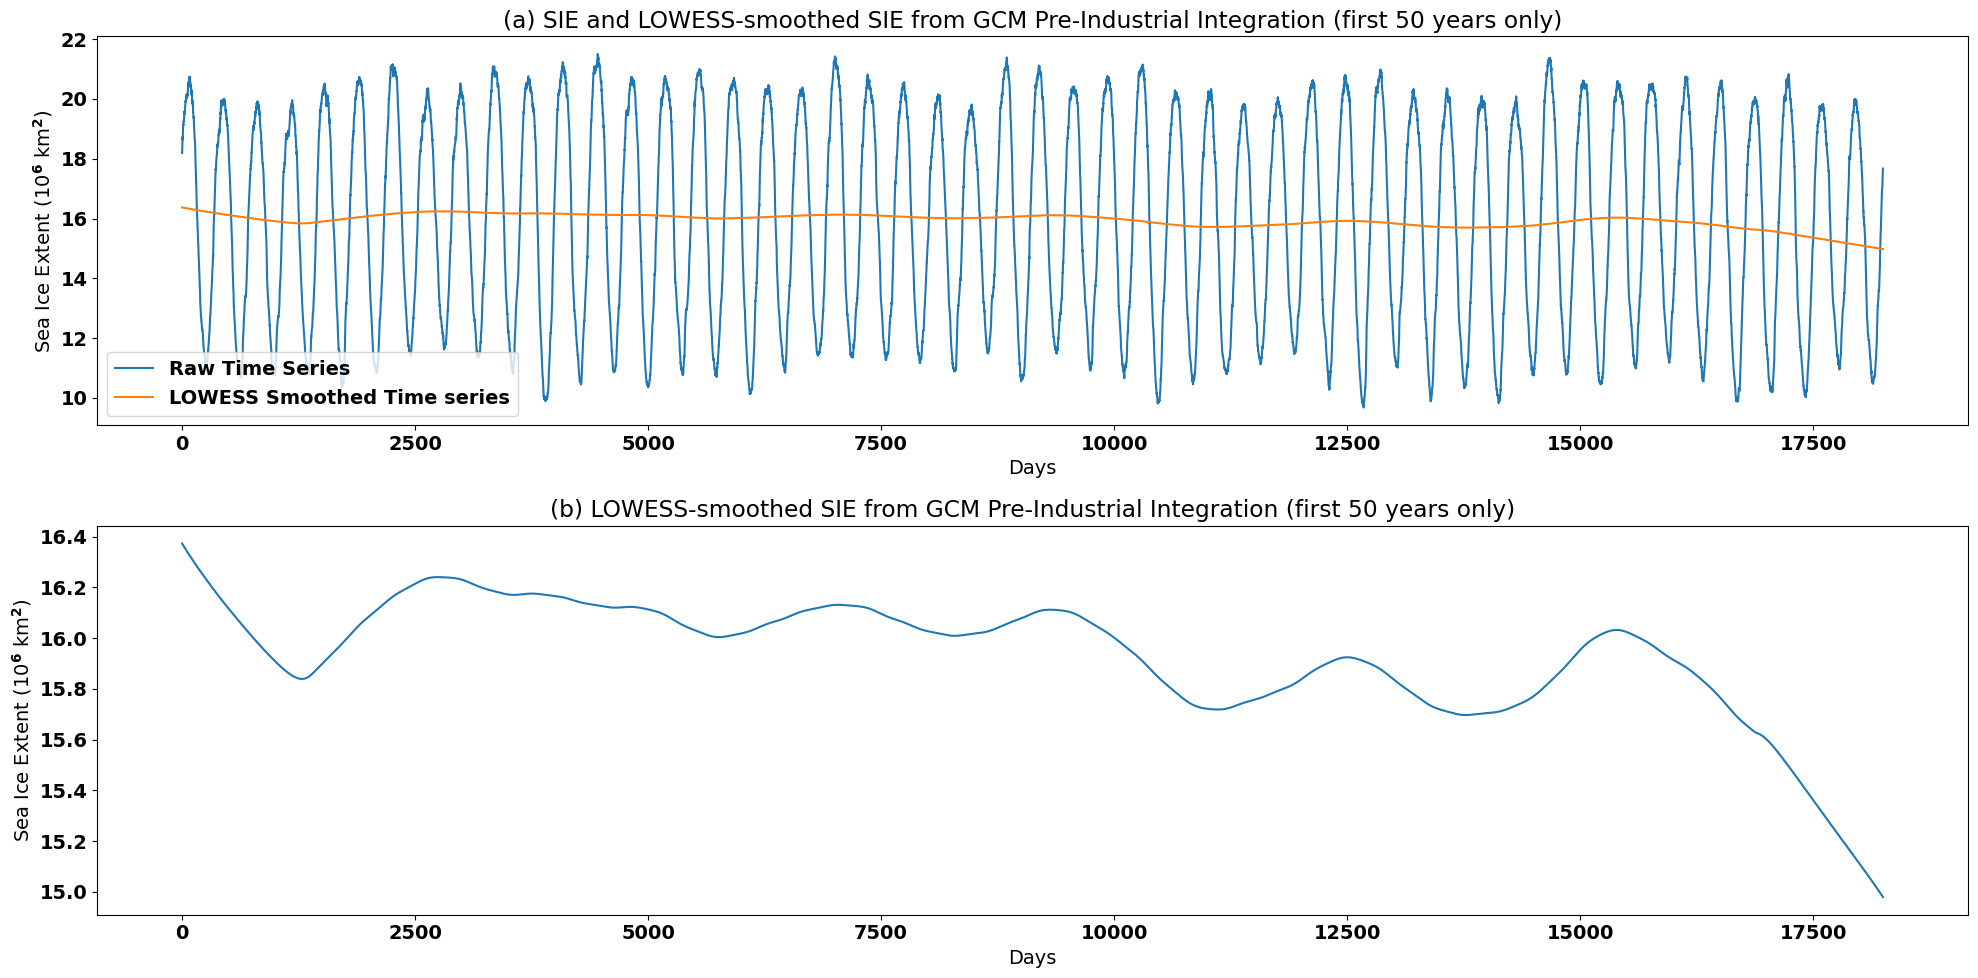

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(sie_ts[0:50*365]/1e12, label = "Raw Time Series")
plt.plot(sie_lfit/1e12, label='LOWESS Smoothed Time series')
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(a) SIE and LOWESS-smoothed SIE from GCM Pre-Industrial Integration (first 50 years only)')
plt.legend()
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(sie_lfit/1e12)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(b) LOWESS-smoothed SIE from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

In order to remove the seasonal cyle using LOWESS smoothing, we generated a *very* smooth time series. The choice of method often depends on the variability that you would like to retain in your filtered time series.